In [ ]:
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cpu.html
!pip install ogb  # for datasets

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.3/497.3 kB 53.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.7/745.7 kB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.5/208.5 kB 414.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7026 sha256=ad8471eebd3f21686ac13ebc929cb05513f2db5f0f212a6601dfcf5f557e4a04
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [ ]:
from torch_geometric.data import Data
from torch_geometric import nn
from torch_geometric.datasets import Amazon
import torch_geometric.transforms as T
import torch
from torch_geometric.nn import GCNConv
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import json
import pickle
from google.colab import files

In [ ]:
# Prepare the Amazon Computers Dataset
amazon_computers = Amazon(root='./data/', name='computers')
amazon_computers = amazon_computers[0]

Processing...
Done!


In [ ]:
num_nodes = amazon_computers.num_nodes
print('Amazon computers has {} nodes'.format(num_nodes))

num_edges = amazon_computers.num_edges
print('Amazon computers has {} edges'.format(num_edges))

is_directed = amazon_computers.is_directed()
print("graph is directed or not:", is_directed)

Amazon computers has 13752 nodes
Amazon computers has 491722 edges
graph is directed or not: False


In [ ]:
transform = T.RandomNodeSplit(split='train_rest', num_val=0.1, num_test=0.1)
data = transform(amazon_computers)

In [ ]:
node_feature = data.x

train_node_feature = node_feature[data.train_mask]
valid_node_feature = node_feature[data.val_mask]
test_node_feature = node_feature[data.test_mask]

print("number of nodes in train set,", train_node_feature.shape[0])
print("number of nodes in valid set,", valid_node_feature.shape[0])
print("number of nodes in test set,", test_node_feature.shape[0])

number of nodes in train set, 11002
number of nodes in valid set, 1375
number of nodes in test set, 1375


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Functions for model training and testing

In [ ]:
def train(model, data, optimizer, loss_fn):
    model.to(device)
    data.to(device)
    loss = 0

    model.train()
    optimizer.zero_grad()
    y_pred = model(data.x, data.edge_index)
    loss = loss_fn(y_pred[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def test(model, data, get_attn=False):
    model.to(device)
    data.to(device)

    accuracy_list = [0, 0, 0]

    if not get_attn:
        predictions = model(data.x, data.edge_index)
    else:
        predictions, (indices, attn_scores) = model(data.x, data.edge_index, get_attn=True)
    # predictions, (indices, attn_scores) = model(data.x, data.edge_index, get_attn=True)
    train_acc = (torch.argmax(predictions[data.train_mask], dim=1) == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
    val_acc = (torch.argmax(predictions[data.val_mask], dim=1) == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
    test_acc = (torch.argmax(predictions[data.test_mask], dim=1) == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
    accuracy_list = [train_acc, val_acc, test_acc]

    if get_attn:
        return accuracy_list, (indices, attn_scores)
    else:
        return accuracy_list #train_acc, val_acc, test_acc

def get_num_classes(data):

  num_classes = int(max(data.y) + 1)

  return num_classes

In [ ]:
import numpy as np
def aggregate_attention_scores(edge_index, attention_scores, num_nodes, aggregation='mean'):
    attention_sum = np.zeros(num_nodes)
    attention_count = np.zeros(num_nodes)

    for i in range(edge_index.shape[1]):
        node1, node2 = edge_index[:, i]
        score = attention_scores[i]

        attention_sum[node1] += score
        attention_sum[node2] += score

        attention_count[node1] += 1
        attention_count[node2] += 1

    if aggregation == 'mean':
        attention_count[attention_count == 0] = 1
        return attention_sum / attention_count
    elif aggregation == 'sum':
        return attention_sum
    else:
        raise ValueError("Invalid aggregation method")

import matplotlib.pyplot as plt

def plot_aggregated_attention(aggregated_attention):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(aggregated_attention)), aggregated_attention)
    plt.xlabel('Node Index')
    plt.ylabel('Aggregated Attention Score')
    plt.title('Aggregated Attention Scores per Node')
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_distribution(attention_scores, model):
    attention_scores = attention_scores.squeeze().cpu().numpy()

    plt.figure(figsize=(10, 6))
    sns.histplot(attention_scores, kde=True, bins=30, color='blue')
    plt.title(f'{model} Distribution of Attention Scores')
    plt.xlabel('Attention Score')
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def extract_data_and_compute_stats(runs):
    train_runs, valid_runs, test_runs, attention_runs = [], [], [], []

    for run in runs:
        train_runs.append(run['train'])
        valid_runs.append(run['valid'])
        test_runs.append(run['test'])
        if 'aggregated_attention' in runs:
            attention_runs.append(run['aggregated_attention'])

    train_runs = np.array(train_runs)
    valid_runs = np.array(valid_runs)
    test_runs = np.array(test_runs)
    attention_runs = np.array(attention_runs)

    train_mean, train_std = np.mean(train_runs, axis=0), np.std(train_runs, axis=0)
    valid_mean, valid_std = np.mean(valid_runs, axis=0), np.std(valid_runs, axis=0)
    test_mean, test_std = np.mean(test_runs, axis=0), np.std(test_runs, axis=0)
    attention_mean = np.mean(attention_runs, axis=0)

    return train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean

def plot_with_std(x_values, y_means, y_stds, labels, title):
    plt.figure(figsize=(10, 6))
    for y_mean, y_std, label in zip(y_means, y_stds, labels):
        plt.plot(x_values, y_mean, label=label)
        plt.fill_between(x_values, y_mean - y_std, y_mean + y_std, alpha=0.2)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.show()

In [ ]:
def run_experiment(data, model_type, num_epochs, lr, num_runs, hidden_channels=200, get_attn=False, num_heads=1, use_concat=False):
    num_features = data.num_features
    num_classes = get_num_classes(data)
    seeds=[42, 2226, 174]

    loss_fn = nn.CrossEntropyLoss()

    total_record = []

    for i in range(num_runs):
        torch.manual_seed(seeds[i])
        np.random.seed(seeds[i])
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seeds[i])
            torch.cuda.manual_seed_all(seeds[i])

        if model_type == "gatv2":
            model = GATv2(num_features, hidden_channels, num_classes, num_heads=num_heads, use_concat=use_concat).to(device)
        elif model_type == "transformer":
            model = GraphTransformer(num_features, hidden_channels, num_classes, num_heads=num_heads, use_concat=num_heads).to(device)
        else:
            model = GCN(num_features, hidden_channels, num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-3)

        record = {'train': [], 'valid': [], 'test': []}
        for epoch in tqdm(range(1, num_epochs + 1)):
            loss = train(model, data, optimizer, loss_fn)

            if epoch == num_epochs and num_heads == 1 and get_attn:
                accs, (indices, attn_scores) = test(model, data, True)
                aggregated_attention = aggregate_attention_scores(indices, attn_scores.squeeze(), 13752, aggregation='mean')
                record['attn_scores'] = attn_scores
                record['indices'] = indices
                # record['aggregated_attention'] = aggregated_attention
                # plot_aggregated_attention(aggregated_attention)
            else:
                accs = test(model, data)

            # print(f"\nAfter {epoch} epochs training, train: {accs[0]}, val: {accs[1]}, test: {accs[2]}")
            record['train'].append(accs[0])
            record['valid'].append(accs[1])
            record['test'].append(accs[2])

        total_record.append(record)

    # with open(f'{model_type}_{lr}_nh_{num_heads}.pkl', 'wb') as file:
    #     pickle.dump(total_record, file)
    # files.download(f'{model_type}_{lr}_nh_{num_heads}.pkl')

    return total_record

In [ ]:
def convert_tensors_to_lists(obj):
    """
    Recursively convert tensors in a nested structure to lists.
    """
    if isinstance(obj, torch.Tensor):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {k: convert_tensors_to_lists(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [convert_tensors_to_lists(v) for v in obj]
    else:
        return obj

## GCN

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.relu = torch.nn.ReLU()

    def forward(self, node_feature, edge_index):
        output = self.conv1(node_feature, edge_index)
        output = self.relu(output)
        output = self.conv2(output, edge_index)
        return output


In [ ]:
lrs = [1e-3, 1e-4, 1e-5]
for lr in lrs:
    gcn_record = run_experiment(data, "gcn", 100, lr, 3, hidden_channels=100, get_attn=False)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(gcn_record)
    print(f"When learning rate is {lr}")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")

100%|██████████| 100/100 [00:02<00:00, 40.78it/s]


When learning rate is 0.001
train:0.8755983760528389, 0.0005668147286514411
valid:0.8707878787878788, 0.0024722518853783227
test:0.8630303030303029, 0.0018141369147994864


100%|██████████| 100/100 [00:02<00:00, 40.93it/s]


When learning rate is 0.0001
train:0.8755680785311762, 0.0005602994003789246
valid:0.8707878787878788, 0.0024722518853783227
test:0.8630303030303029, 0.0018141369147994864


100%|██████████| 100/100 [00:02<00:00, 40.57it/s]

When learning rate is 1e-05
train:0.8755983760528389, 0.0005668147286514411
valid:0.8707878787878788, 0.0024722518853783227
test:0.8630303030303029, 0.0018141369147994864


## GATv2

###model

In [ ]:
from torch_geometric.nn import GATv2Conv
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, use_concat):
        super().__init__()
        if use_concat == False:
            self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads, concat=False)
            self.conv2 = GATv2Conv(hidden_channels, out_channels, heads=num_heads, concat=False)
        else:
            self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=num_heads, concat=True)
            self.conv2 = GATv2Conv(num_heads*hidden_channels, out_channels, heads=num_heads, concat=False)
        self.relu = torch.nn.ReLU()

    def forward(self, node_feature, edge_index, get_attn=False):

        output = None

        output = self.conv1(node_feature, edge_index)
        output = self.relu(output)
        output, (indices, attn_scores) = self.conv2(output, edge_index, return_attention_weights=get_attn)
        # output = self.conv2(output, edge_index)
        if get_attn:
            return output, (indices, attn_scores)
        else:
            return output

###gatv2_results

100%|██████████| 100/100 [01:39<00:00,  1.00it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


When #head = 1:
train:0.9198327576804218, 0.003826854043569728
valid:0.8984242424242425, 0.0012361259426891796
test:0.8807272727272727, 0.004483210183977468


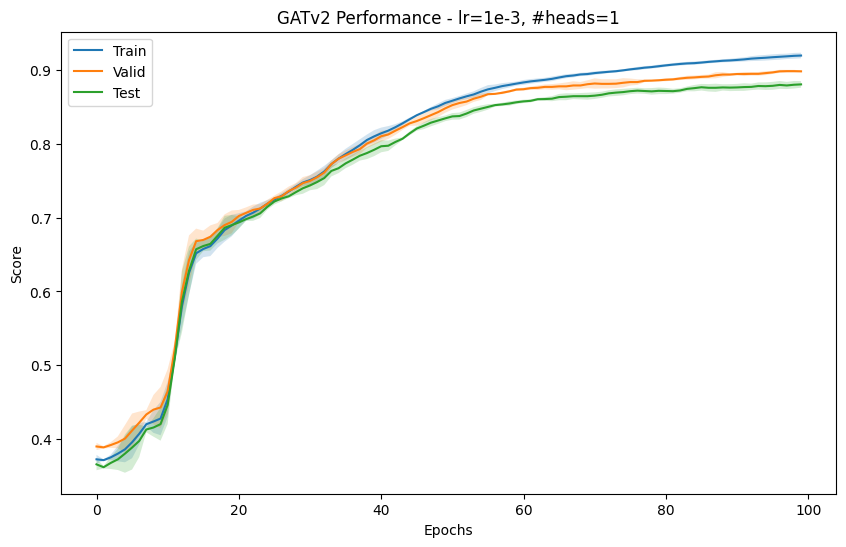

100%|██████████| 100/100 [00:19<00:00,  5.24it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 3:
train:0.941525783190935, 0.0045870487820498865
valid:0.9151515151515152, 0.00224814993830197
test:0.8967272727272727, 0.002375262780880664


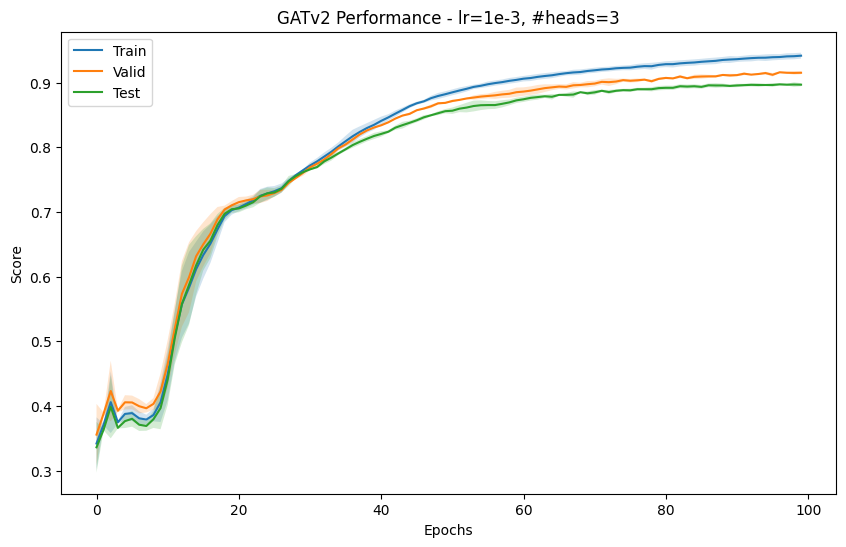

100%|██████████| 100/100 [00:31<00:00,  3.16it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 5:
train:0.9562200811973579, 0.0021333414218364694
valid:0.9187878787878788, 0.0036282738295989533
test:0.9023030303030303, 0.0038177007873996974


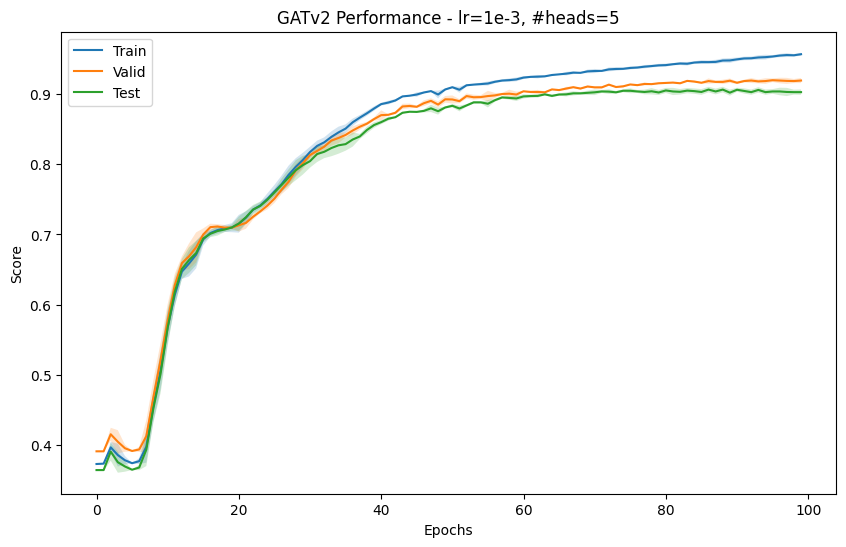

100%|██████████| 100/100 [00:44<00:00,  2.24it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 7:
train:0.9600072714051991, 0.002526529932665473
valid:0.9214545454545454, 0.0048605909468517495
test:0.9032727272727272, 0.0025883826065530077


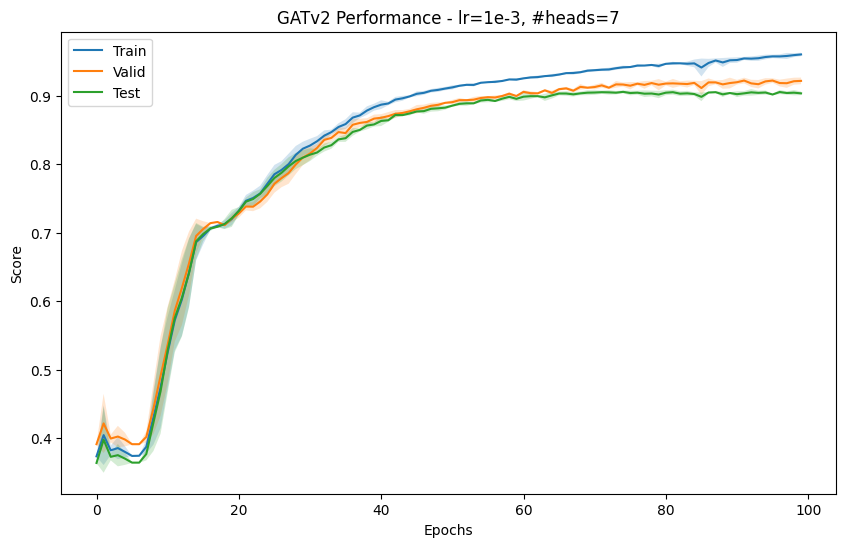

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 10:
train:0.9633702963097619, 0.003920691292024591
valid:0.9229090909090908, 0.004156709866541163
test:0.9025454545454545, 0.00272120537219922


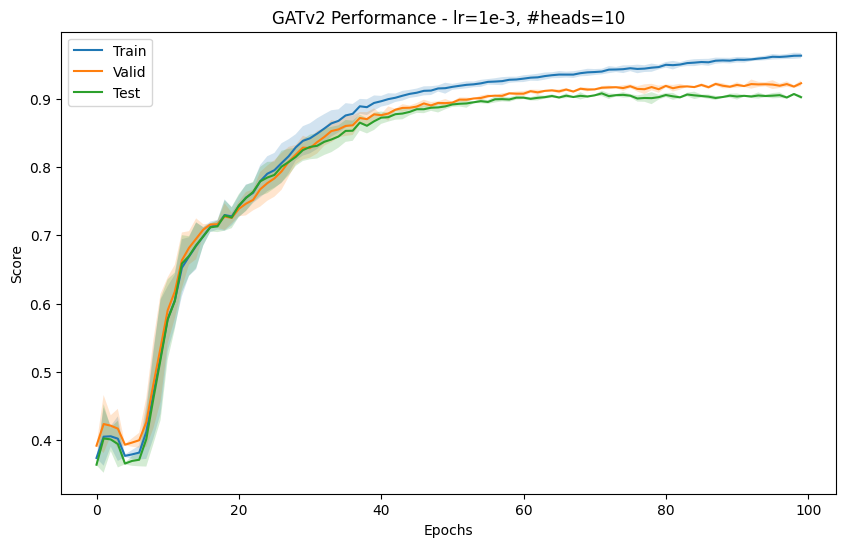

In [ ]:
nh = [1,3,5,7,10]
total_records = []
for h in nh:
    gatv2_record = run_experiment(data, "gatv2", 100, 1e-3, 3, hidden_channels=100, get_attn=True, num_heads=h, use_concat=True)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(gatv2_record)
    print(f"When #head = {h}:")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")
    total_records.append(gatv2_record)
    plot_with_std(range(100), [train_mean, valid_mean, test_mean], [train_std, valid_std, test_std], ['Train', 'Valid', 'Test'], f'GATv2 Performance - lr=1e-3, #heads={h}')

100%|██████████| 100/100 [01:35<00:00,  1.05it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


When #head = 1:
train:0.919347997333818, 0.0030285400229290924
valid:0.8984242424242425, 0.005767455637997743
test:0.8887272727272727, 0.0015710886541594469


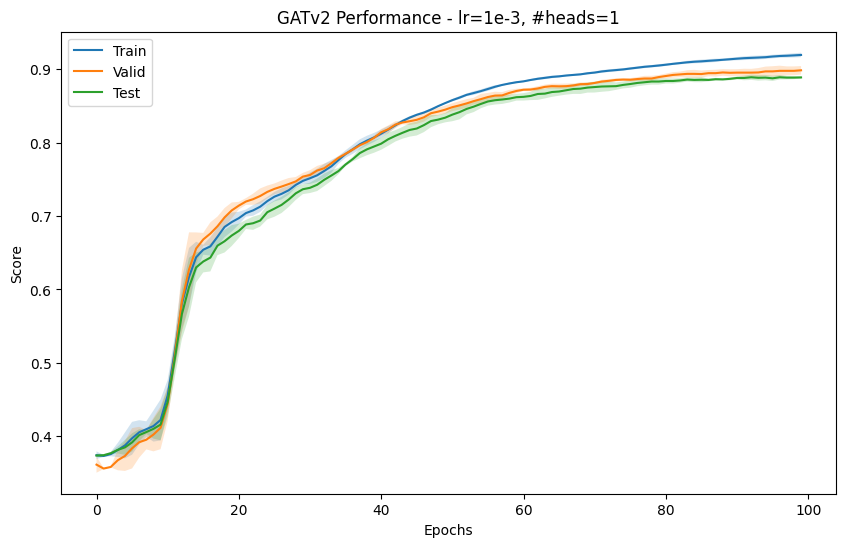

100%|██████████| 100/100 [00:18<00:00,  5.32it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 3:
train:0.9407986426710294, 0.005199358389908049
valid:0.9076363636363637, 0.003708377828067466
test:0.9054545454545454, 0.0048605909468517495


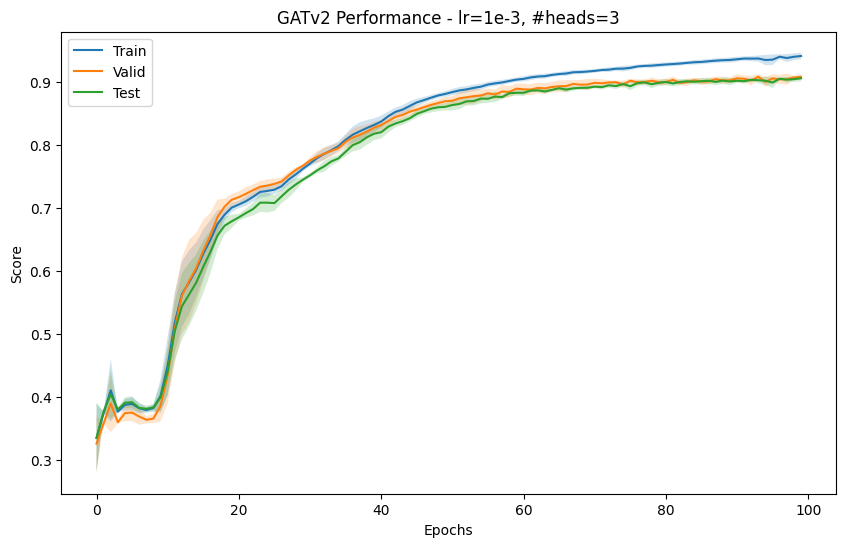

100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 5:
train:0.9551899654608254, 0.0020660155270232137
valid:0.9139393939393939, 0.003270481833510806
test:0.9066666666666667, 0.0030472254763579698


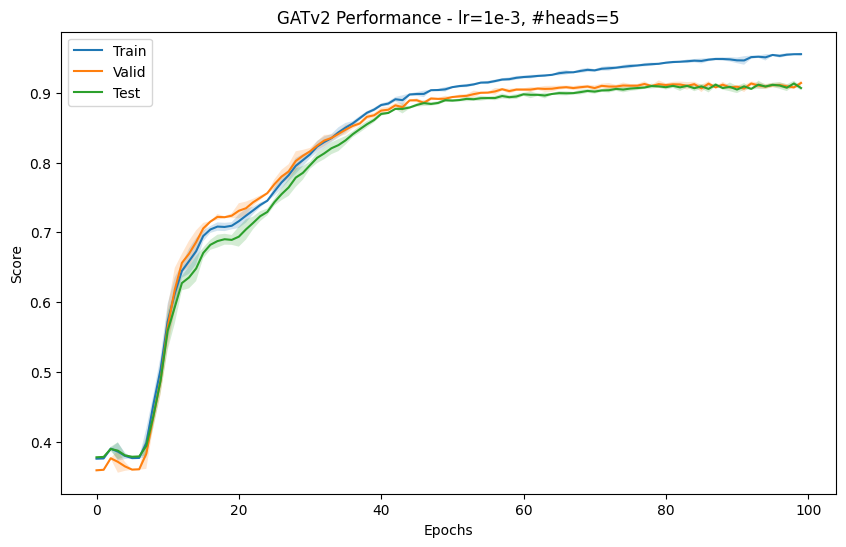

100%|██████████| 100/100 [00:43<00:00,  2.30it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 7:
train:0.9454947585287524, 0.014063272791980731
valid:0.8957575757575759, 0.01098692770290875
test:0.9061818181818181, 0.010285189544531614


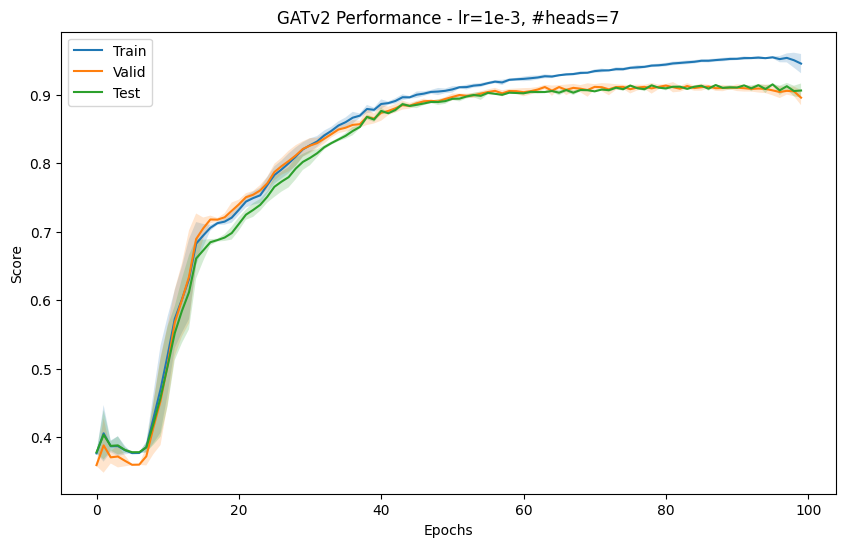

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 10:
train:0.9614918499666727, 0.002219383938897469
valid:0.9139393939393939, 0.001908850393699832
test:0.9149090909090908, 0.004637848841141558


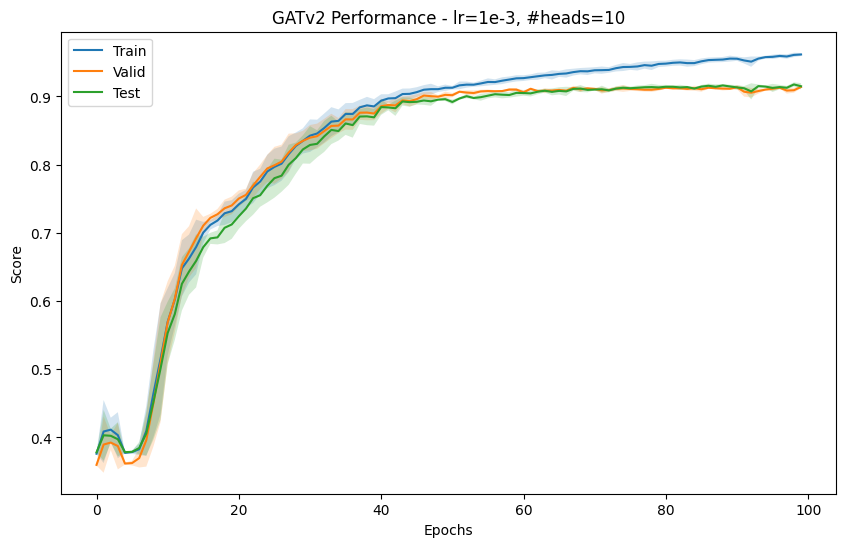

In [ ]:
nh = [1,3,5,7,10]
total_records = []
summary = []
for h in nh:
    gatv2_record = run_experiment(data, "gatv2", 100, 1e-4, 3, hidden_channels=100, get_attn=True, num_heads=h, use_concat=True)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(gatv2_record)
    print(f"When #head = {h}:")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")
    summary.append([f"train:{train_mean[-1]}, {train_std[-1]}", f"valid:{valid_mean[-1]}, {valid_std[-1]}", f"test:{test_mean[-1]}, {test_std[-1]}"])
    total_records.append(gatv2_record)
    plot_with_std(range(100), [train_mean, valid_mean, test_mean], [train_std, valid_std, test_std], ['Train', 'Valid', 'Test'], f'GATv2 Performance - lr=1e-4, #heads={h}')

print("For GATv2 1e-4:")
for s in summary:
    print(s)

In [ ]:
print("For GATv2 1e-4:")
for s in summary:
    print(s)

For GATv2 1e-4:
['train:0.919347997333818, 0.0030285400229290924', 'valid:0.8984242424242425, 0.005767455637997743', 'test:0.8887272727272727, 0.0015710886541594469']
['train:0.9407986426710294, 0.005199358389908049', 'valid:0.9076363636363637, 0.003708377828067466', 'test:0.9054545454545454, 0.0048605909468517495']
['train:0.9551899654608254, 0.0020660155270232137', 'valid:0.9139393939393939, 0.003270481833510806', 'test:0.9066666666666667, 0.0030472254763579698']
['train:0.9454947585287524, 0.014063272791980731', 'valid:0.8957575757575759, 0.01098692770290875', 'test:0.9061818181818181, 0.010285189544531614']
['train:0.9614918499666727, 0.002219383938897469', 'valid:0.9139393939393939, 0.001908850393699832', 'test:0.9149090909090908, 0.004637848841141558']


100%|██████████| 100/100 [00:06<00:00, 15.29it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


When #head = 1:
train:0.9191662122038418, 0.0028408672773995035
valid:0.8984242424242425, 0.005767455637997743
test:0.888969696969697, 0.0019088503936998322


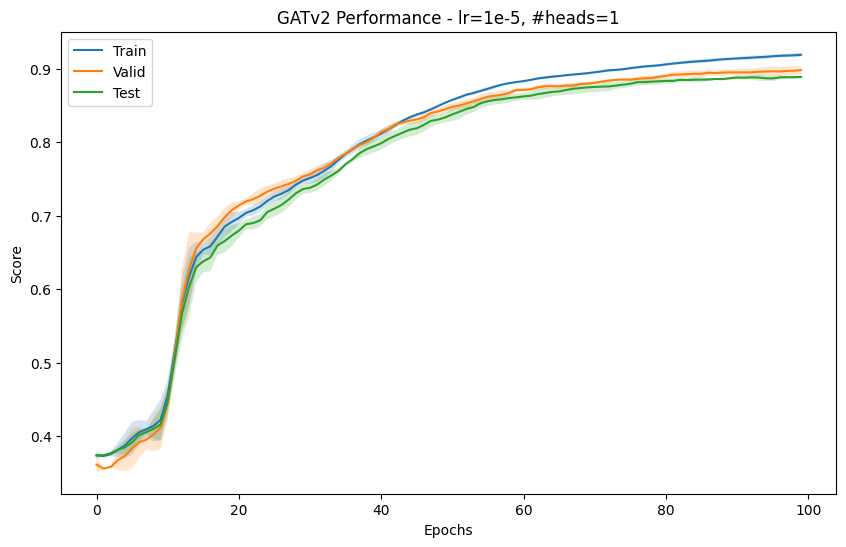

100%|██████████| 100/100 [00:18<00:00,  5.35it/s]


When #head = 3:
train:0.9412228079743077, 0.004384460706572336
valid:0.9025454545454545, 0.005442410744398489
test:0.9061818181818181, 0.0025883826065530597


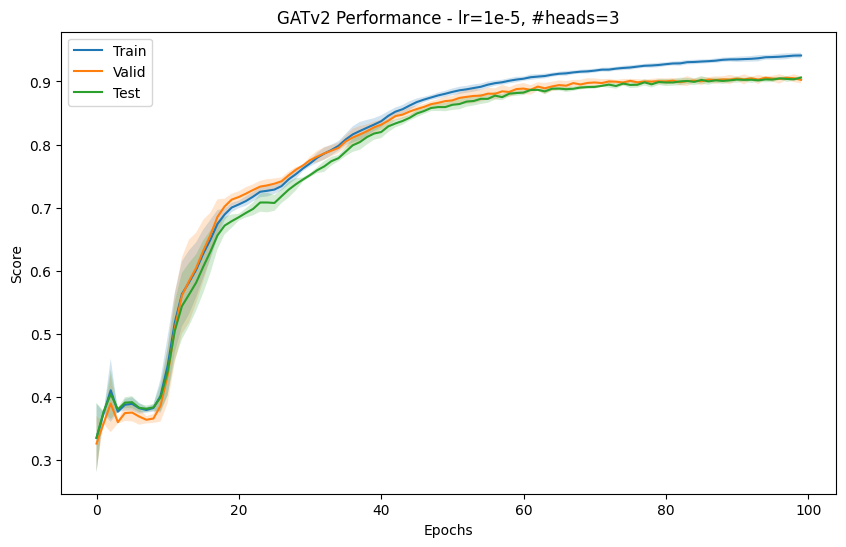

100%|██████████| 100/100 [00:30<00:00,  3.24it/s]

When #head = 5:
train:0.9563715688056718, 0.0016858059435549324
valid:0.9107878787878788, 0.0029888067893183083
test:0.9103030303030303, 0.005322302642448544


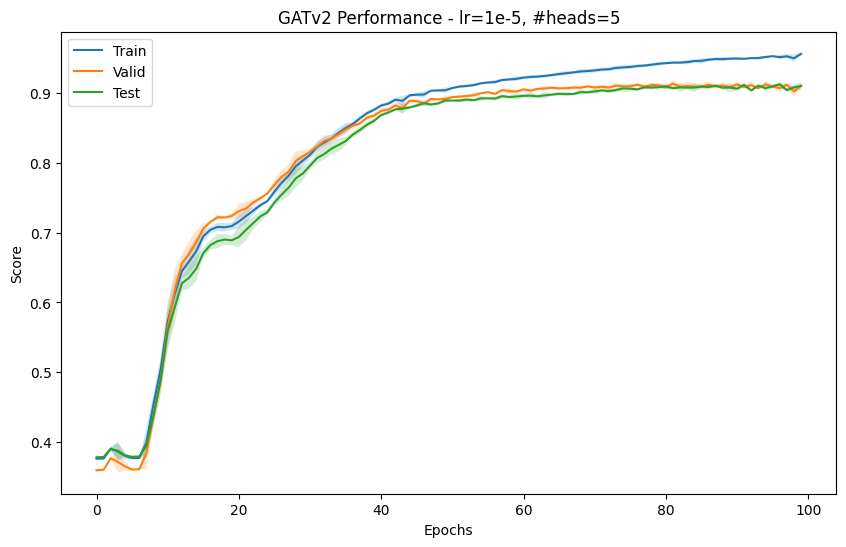

100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

When #head = 7:
train:0.9533115191177362, 0.004853091784978438
valid:0.9027878787878788, 0.006094450952715889
test:0.9127272727272727, 0.0021410329372915705


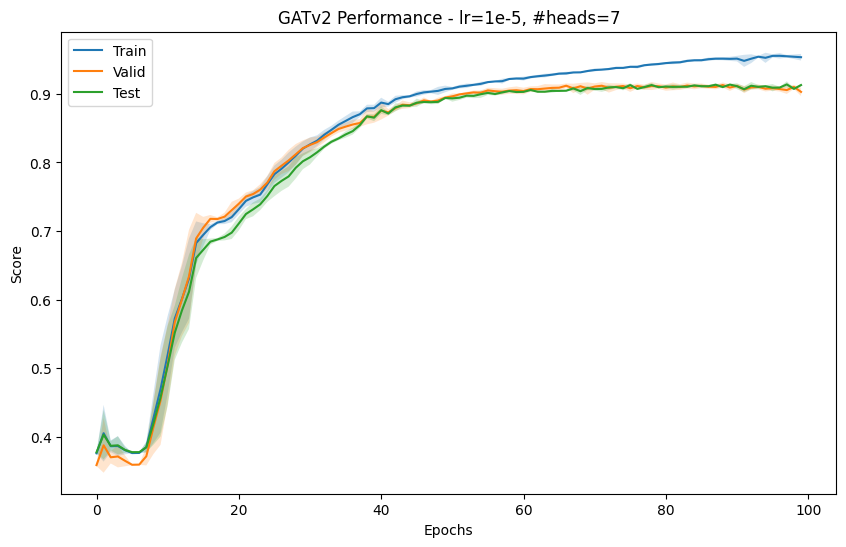

100%|██████████| 100/100 [01:01<00:00,  1.62it/s]

When #head = 10:
train:0.9615221474883354, 0.002490670049635145
valid:0.911030303030303, 0.003953819740678821
test:0.9156363636363637, 0.0020570379089063125


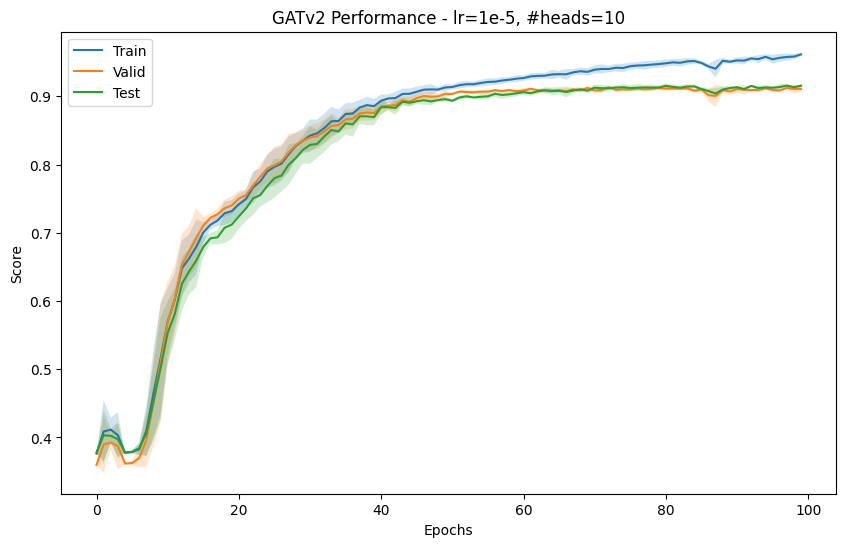

In [ ]:
nh = [1,3,5,7,10]
total_records = []
summary = []
for h in nh:
    gatv2_record = run_experiment(data, "gatv2", 100, 1e-5, 3, hidden_channels=100, get_attn=False, num_heads=h, use_concat=True)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(gatv2_record)
    print(f"When #head = {h}:")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")
    summary.append([f"train:{train_mean[-1]}, {train_std[-1]}", f"valid:{valid_mean[-1]}, {valid_std[-1]}", f"test:{test_mean[-1]}, {test_std[-1]}"])
    total_records.append(gatv2_record)
    plot_with_std(range(100), [train_mean, valid_mean, test_mean], [train_std, valid_std, test_std], ['Train', 'Valid', 'Test'], f'GATv2 Performance - lr=1e-5, #heads={h}')

In [ ]:
print("For GATv2 1e-5:")
for s in summary:
    print(s)

For GATv2 1e-5:
['train:0.9191662122038418, 0.0028408672773995035', 'valid:0.8984242424242425, 0.005767455637997743', 'test:0.888969696969697, 0.0019088503936998322']
['train:0.9412228079743077, 0.004384460706572336', 'valid:0.9025454545454545, 0.005442410744398489', 'test:0.9061818181818181, 0.0025883826065530597']
['train:0.9563715688056718, 0.0016858059435549324', 'valid:0.9107878787878788, 0.0029888067893183083', 'test:0.9103030303030303, 0.005322302642448544']
['train:0.9533115191177362, 0.004853091784978438', 'valid:0.9027878787878788, 0.006094450952715889', 'test:0.9127272727272727, 0.0021410329372915705']
['train:0.9615221474883354, 0.002490670049635145', 'valid:0.911030303030303, 0.003953819740678821', 'test:0.9156363636363637, 0.0020570379089063125']


## GraphTransformer

### model

In [ ]:
from torch_geometric.nn import TransformerConv
class GraphTransformer(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads, use_concat):
        super().__init__()
        self.relu = torch.nn.ReLU()
        if use_concat == False:
            self.conv1 = TransformerConv(in_channels, hidden_channels, heads=num_heads, concat=False)
            self.conv2 = TransformerConv(hidden_channels, out_channels, heads=num_heads, concat=False)
        else:
            self.conv1 = TransformerConv(in_channels, hidden_channels, heads=num_heads, concat=True)
            self.conv2 = TransformerConv(num_heads*hidden_channels, out_channels, heads=num_heads, concat=False)

    def forward(self, node_feature, edge_index, get_attn=False):

        output = None

        output = self.conv1(node_feature, edge_index)
        output = self.relu(output)
        output, (indices, attn_scores) = self.conv2(output, edge_index, return_attention_weights=get_attn)
        if get_attn:
            return output, (indices, attn_scores)
        else:
            return output

### transformer_results

100%|██████████| 100/100 [01:36<00:00,  1.03it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 1:
train:0.9398897170211477, 0.0009685734328998297
valid:0.9054545454545454, 0.0036120398607882146
test:0.8904242424242425, 0.004377083657034616


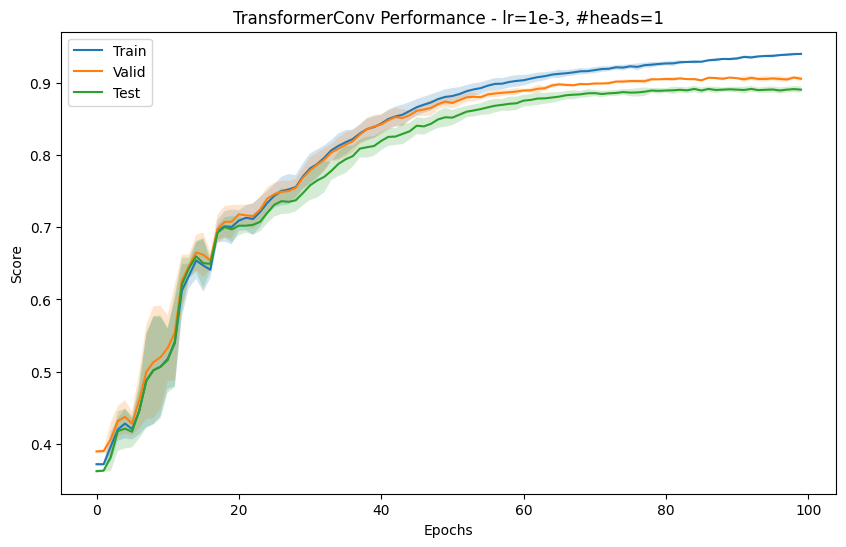

100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 3:
train:0.9614615524450101, 0.0033527736312330882
valid:0.906909090909091, 0.0015710886541594811
test:0.8913939393939394, 0.0028062634915854935


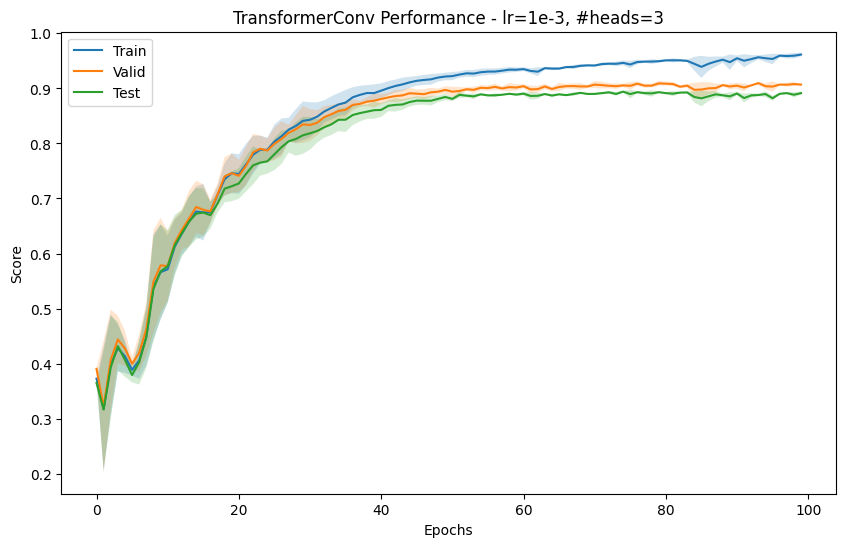

100%|██████████| 100/100 [00:30<00:00,  3.31it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 5:
train:0.9635217839180754, 0.0037507793409523125
valid:0.9081212121212121, 0.002929223266325953
test:0.8991515151515151, 0.0029292232663259317


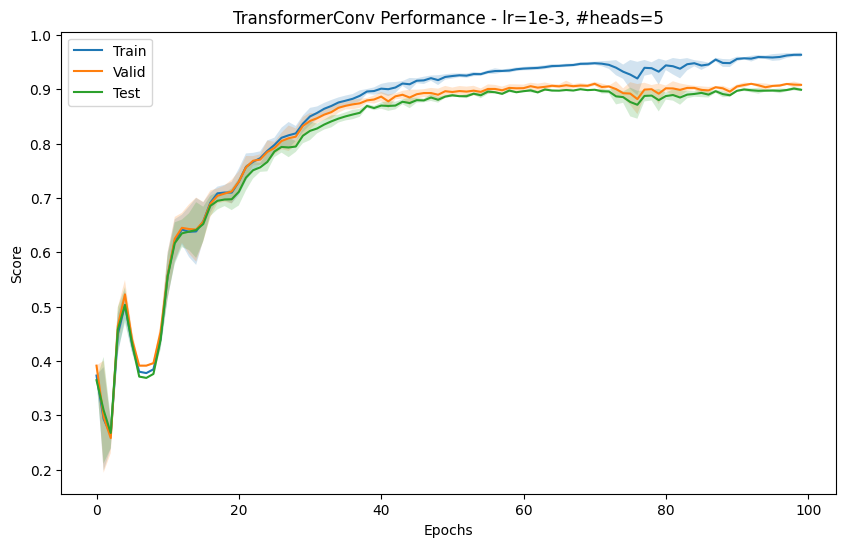

100%|██████████| 100/100 [00:42<00:00,  2.35it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 7:
train:0.9754893049748531, 0.002974408172156542
valid:0.9059393939393939, 0.0009070684573997433
test:0.8926060606060605, 0.0026776632768938722


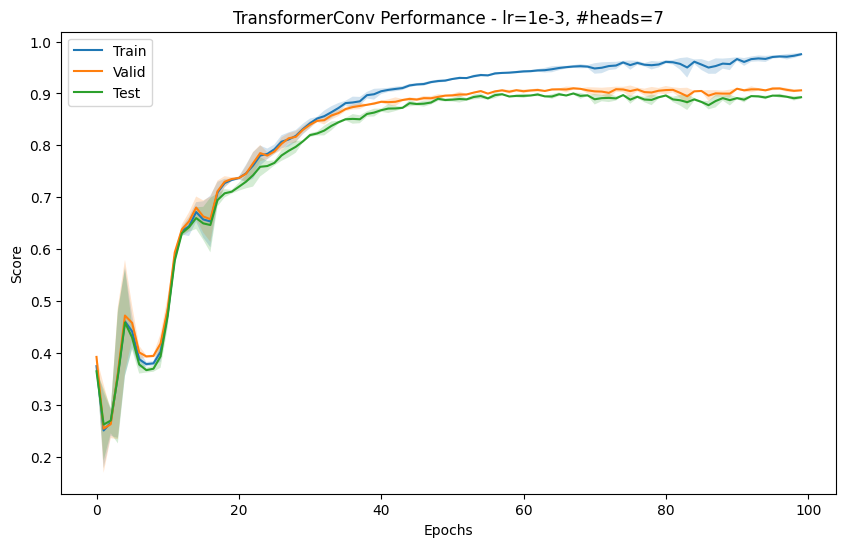

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

When #head = 10:
train:0.9761558504514332, 0.00963070481229931
valid:0.9081212121212121, 0.007158702089810152
test:0.8962424242424243, 0.0009070684573997828


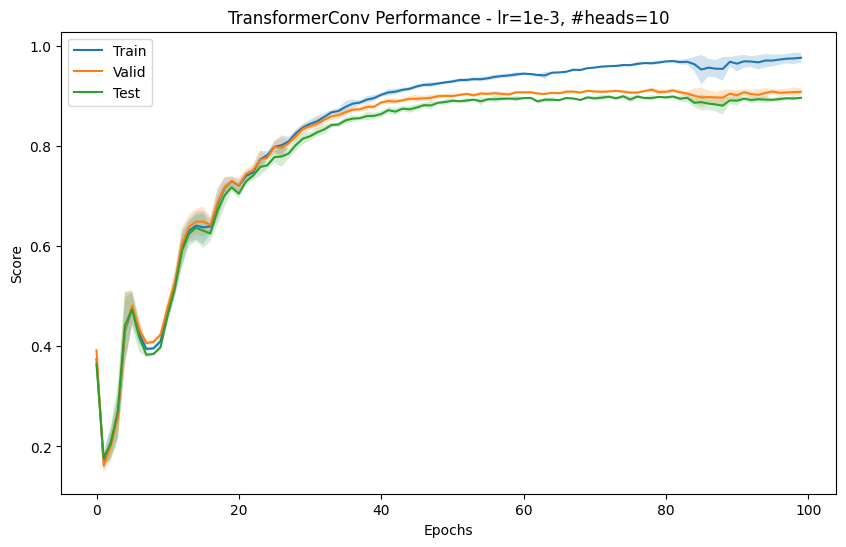

In [ ]:
nh = [1,3,5,7,10]
total_records_trans = []
for h in nh:
    transformer_record = run_experiment(data, "transformer", 100, 1e-3, 3, hidden_channels=100, get_attn=True, num_heads=h, use_concat=True)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(transformer_record)
    print(f"When #head = {h}:")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")
    total_records_trans.append(transformer_record)
    plot_with_std(range(100), [train_mean, valid_mean, test_mean], [train_std, valid_std, test_std], ['Train', 'Valid', 'Test'], f'TransformerConv Performance - lr=1e-3, #heads={h}')

100%|██████████| 100/100 [00:06<00:00, 16.12it/s]
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


When #head = 1:
train:0.9381021632430467, 0.0036545894933693564
valid:0.8993939393939394, 0.003376578976287063
test:0.904, 0.002588382606553039


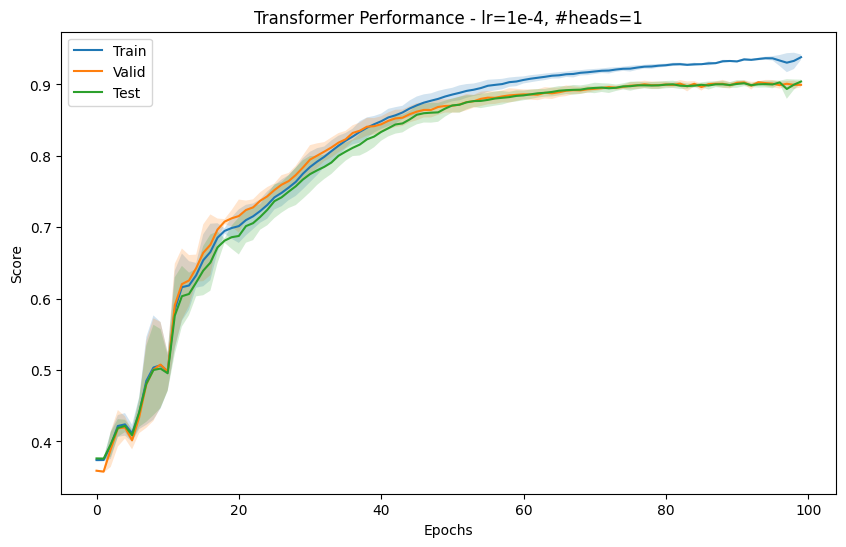

100%|██████████| 100/100 [00:17<00:00,  5.65it/s]


When #head = 3:
train:0.903320608374235, 0.08199148652784298
valid:0.8596363636363636, 0.06448029147716933
test:0.8538181818181818, 0.07052920775115451


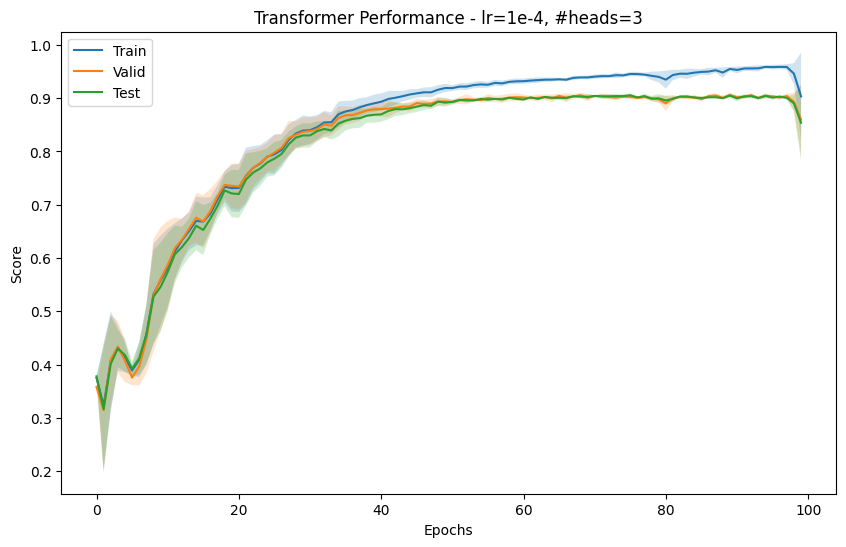

100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


When #head = 5:
train:0.9446161304005333, 0.015778407081961286
valid:0.8984242424242425, 0.005050343431757457
test:0.8962424242424243, 0.008652881598824151


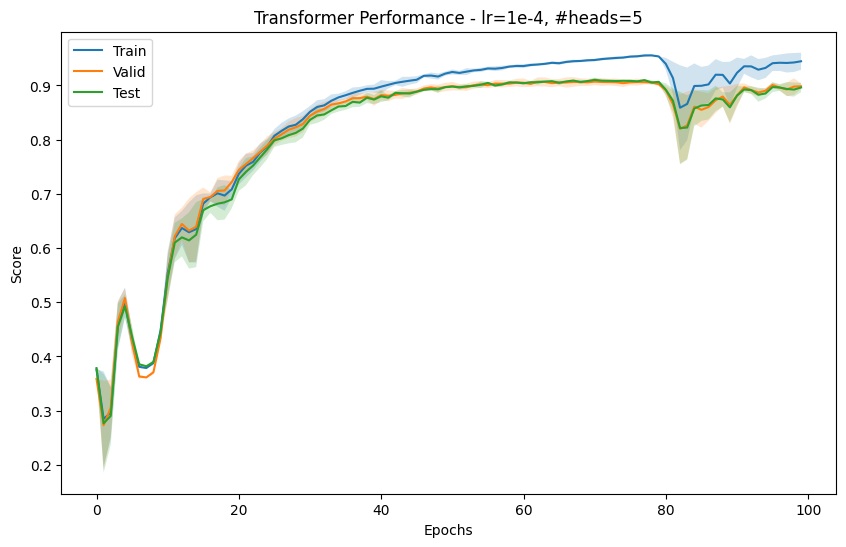

100%|██████████| 100/100 [00:41<00:00,  2.41it/s]


When #head = 7:
train:0.9798521480942859, 0.001821382580765847
valid:0.904969696969697, 0.005485434423750201
test:0.9018181818181817, 0.002588382606553039


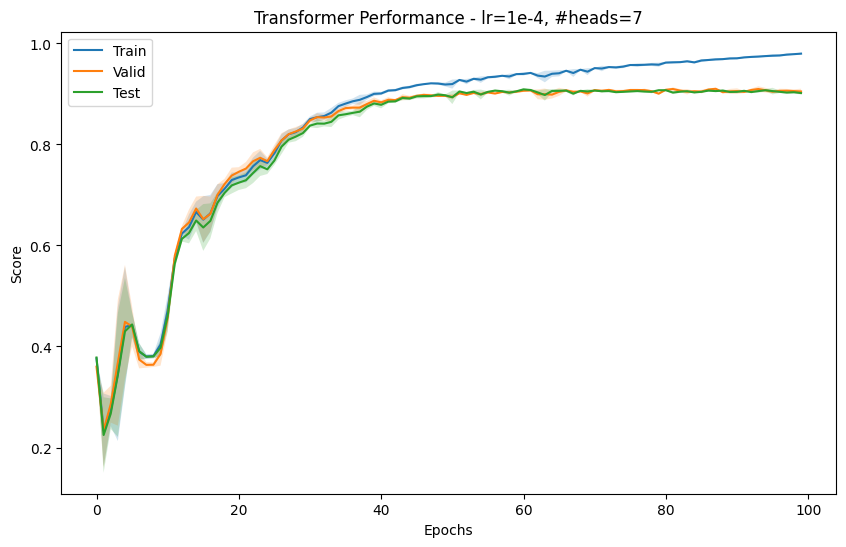

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]

When #head = 10:
train:0.9753681148882022, 0.006461687906626523
valid:0.9059393939393939, 0.00224814993830197
test:0.9090909090909091, 0.0033062258659359634


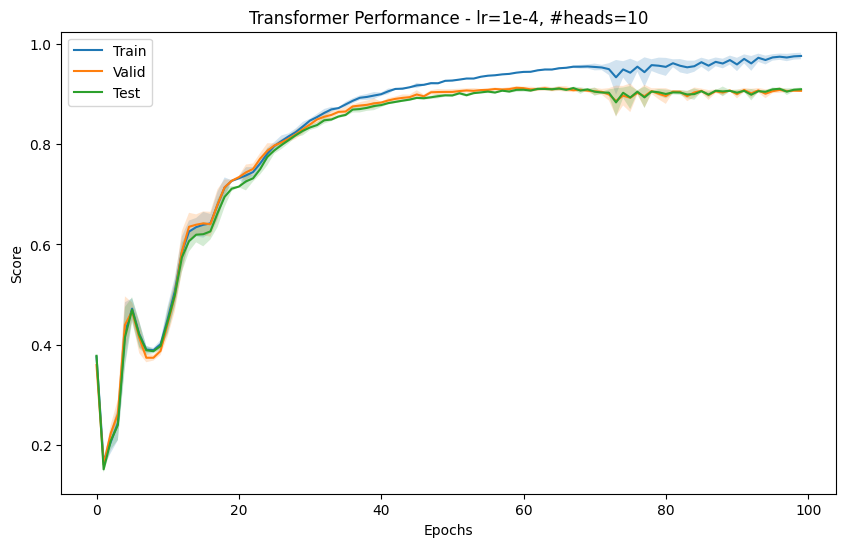

For Transformer 1e-4:
['train:0.9381021632430467, 0.0036545894933693564', 'valid:0.8993939393939394, 0.003376578976287063', 'test:0.904, 0.002588382606553039']
['train:0.903320608374235, 0.08199148652784298', 'valid:0.8596363636363636, 0.06448029147716933', 'test:0.8538181818181818, 0.07052920775115451']
['train:0.9446161304005333, 0.015778407081961286', 'valid:0.8984242424242425, 0.005050343431757457', 'test:0.8962424242424243, 0.008652881598824151']
['train:0.9798521480942859, 0.001821382580765847', 'valid:0.904969696969697, 0.005485434423750201', 'test:0.9018181818181817, 0.002588382606553039']
['train:0.9753681148882022, 0.006461687906626523', 'valid:0.9059393939393939, 0.00224814993830197', 'test:0.9090909090909091, 0.0033062258659359634']


In [ ]:
nh = [1,3,5,7,10]
total_records = []
summary = []
for h in nh:
    gatv2_record = run_experiment(data, "transformer", 100, 1e-4, 3, hidden_channels=100, get_attn=False, num_heads=h, use_concat=True)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(gatv2_record)
    print(f"When #head = {h}:")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")
    summary.append([f"train:{train_mean[-1]}, {train_std[-1]}", f"valid:{valid_mean[-1]}, {valid_std[-1]}", f"test:{test_mean[-1]}, {test_std[-1]}"])
    total_records.append(gatv2_record)
    plot_with_std(range(100), [train_mean, valid_mean, test_mean], [train_std, valid_std, test_std], ['Train', 'Valid', 'Test'], f'Transformer Performance - lr=1e-4, #heads={h}')

print("For Transformer 1e-4:")
for s in summary:
    print(s)

100%|██████████| 100/100 [00:06<00:00, 16.47it/s]


When #head = 1:
train:0.9385566260679875, 0.0031825379749157736
valid:0.8993939393939394, 0.003376578976287063
test:0.9035151515151515, 0.0027427172118750483


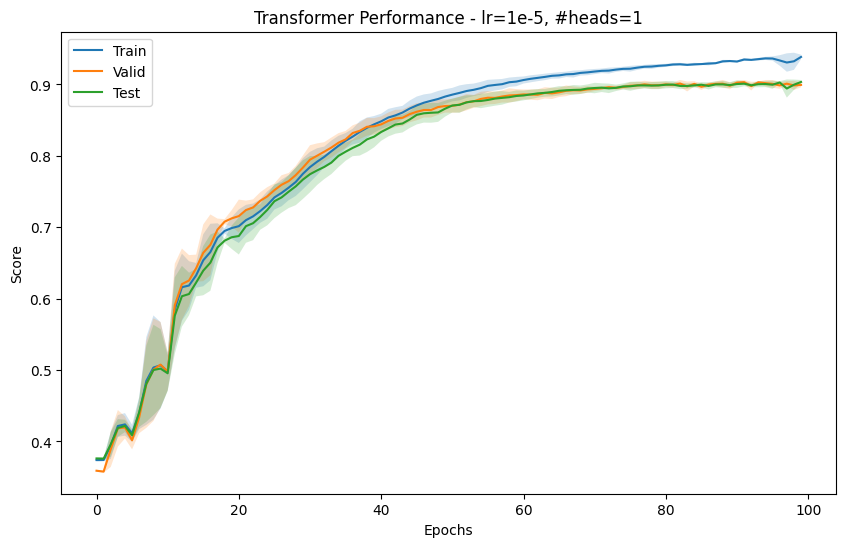

100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


When #head = 3:
train:0.9196812700721081, 0.04586970736318973
valid:0.8736969696969696, 0.036316737433509994
test:0.872, 0.04012981689288838


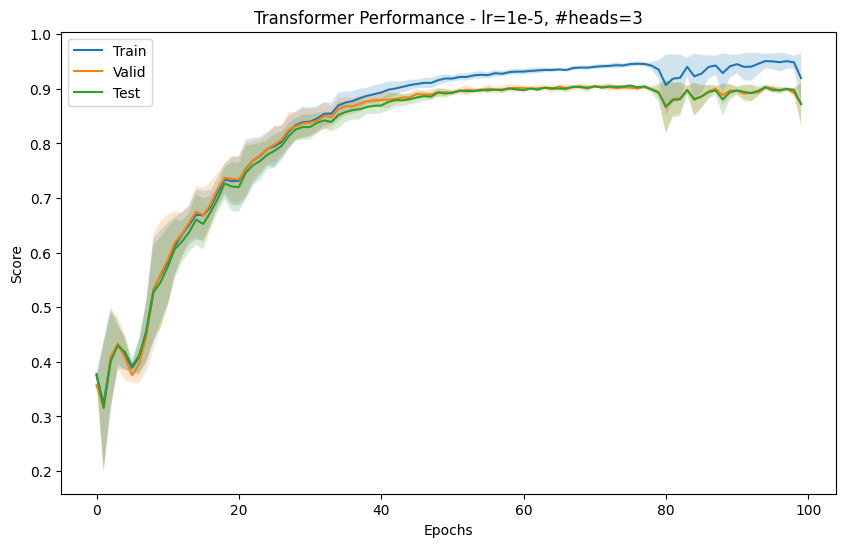

100%|██████████| 100/100 [00:29<00:00,  3.43it/s]


When #head = 5:
train:0.9484639156516996, 0.010487232307053182
valid:0.9013333333333334, 0.011177834553598541
test:0.9047272727272727, 0.004156709866541163


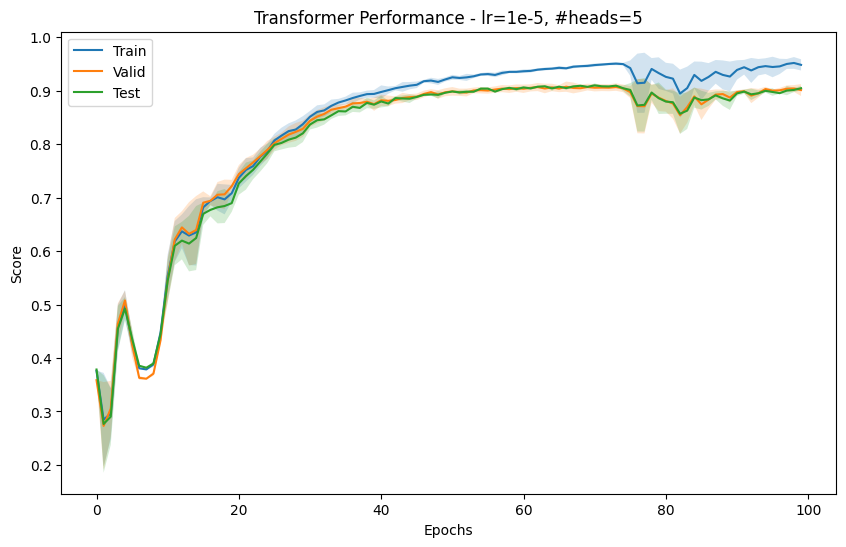

100%|██████████| 100/100 [00:41<00:00,  2.41it/s]

When #head = 7:
train:0.9583712052354117, 0.03243739887319617
valid:0.8964848484848483, 0.011411977983941614
test:0.9013333333333332, 0.007658457696451556


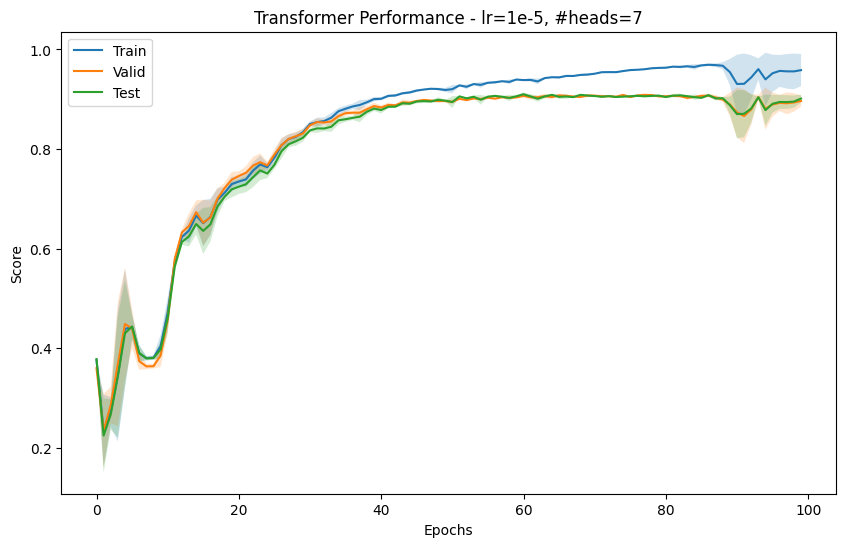

100%|██████████| 100/100 [00:58<00:00,  1.71it/s]

When #head = 10:
train:0.9653699327395019, 0.01936118312723514
valid:0.9047272727272727, 0.0048605909468517495
test:0.906909090909091, 0.006848216674824494


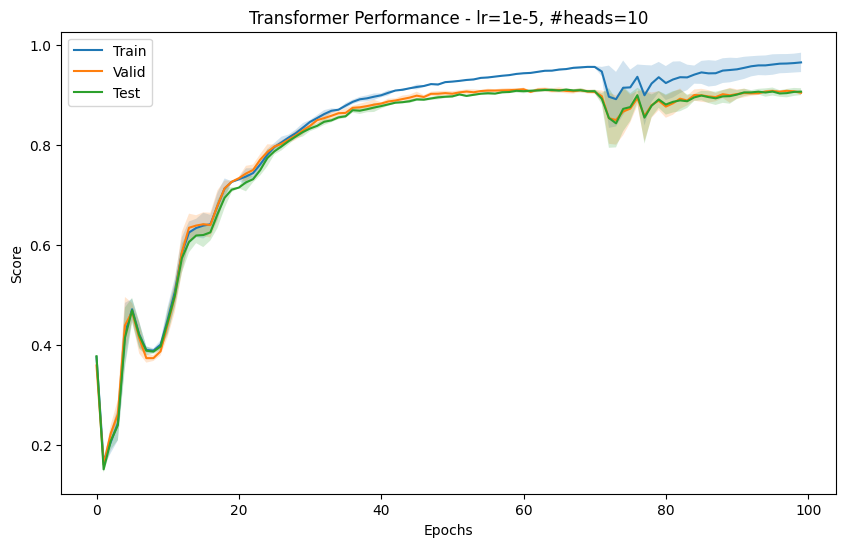

For Transformer 1e-5:
['train:0.9385566260679875, 0.0031825379749157736', 'valid:0.8993939393939394, 0.003376578976287063', 'test:0.9035151515151515, 0.0027427172118750483']
['train:0.9196812700721081, 0.04586970736318973', 'valid:0.8736969696969696, 0.036316737433509994', 'test:0.872, 0.04012981689288838']
['train:0.9484639156516996, 0.010487232307053182', 'valid:0.9013333333333334, 0.011177834553598541', 'test:0.9047272727272727, 0.004156709866541163']
['train:0.9583712052354117, 0.03243739887319617', 'valid:0.8964848484848483, 0.011411977983941614', 'test:0.9013333333333332, 0.007658457696451556']
['train:0.9653699327395019, 0.01936118312723514', 'valid:0.9047272727272727, 0.0048605909468517495', 'test:0.906909090909091, 0.006848216674824494']


In [ ]:
nh = [1,3,5,7,10]
total_records = []
summary = []
for h in nh:
    gatv2_record = run_experiment(data, "transformer", 100, 1e-5, 3, hidden_channels=100, get_attn=False, num_heads=h, use_concat=True)
    train_mean, train_std, valid_mean, valid_std, test_mean, test_std, attention_mean = extract_data_and_compute_stats(gatv2_record)
    print(f"When #head = {h}:")
    print(f"train:{train_mean[-1]}, {train_std[-1]}")
    print(f"valid:{valid_mean[-1]}, {valid_std[-1]}")
    print(f"test:{test_mean[-1]}, {test_std[-1]}")
    summary.append([f"train:{train_mean[-1]}, {train_std[-1]}", f"valid:{valid_mean[-1]}, {valid_std[-1]}", f"test:{test_mean[-1]}, {test_std[-1]}"])
    total_records.append(gatv2_record)
    plot_with_std(range(100), [train_mean, valid_mean, test_mean], [train_std, valid_std, test_std], ['Train', 'Valid', 'Test'], f'Transformer Performance - lr=1e-5, #heads={h}')

print("For Transformer 1e-5:")
for s in summary:
    print(s)

In [ ]:
gat_train_mean, gat_train_std, gat_valid_mean, gat_valid_std, gat_test_mean, gat_test_std, gat_attention_mean = extract_data_and_compute_stats(total_records[0])

In [ ]:
gat_attention_mean

array([0.13360849, 0.01103935, 0.01766837, ..., 0.04022749, 0.01669803,
       0.03635677])

In [ ]:
trans_train_mean, trans_train_std, trans_valid_mean, trans_valid_std, trans_test_mean, trans_test_std, trans_attention_mean = extract_data_and_compute_stats(total_records_trans[0])

In [ ]:
trans_attention_mean

array([0.13929903, 0.00626584, 0.01726692, ..., 0.0289175 , 0.01126578,
       0.05639266])

##Attention Analysis

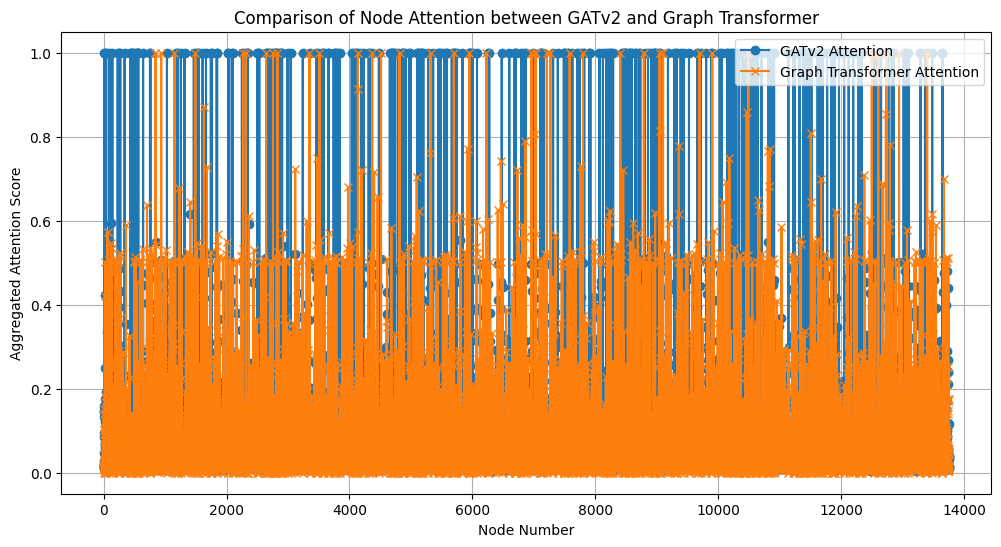

In [ ]:
import matplotlib.pyplot as plt

# Assuming node numbers are simply a range from 0 to the number of nodes - 1
node_numbers = range(len(gat_attention_mean))  # Adjust this if you have a different set of node numbers

plt.figure(figsize=(12, 6))
plt.plot(node_numbers, gat_attention_mean, label='GATv2 Attention', marker='o')
plt.plot(node_numbers, trans_attention_mean, label='Graph Transformer Attention', marker='x')

plt.title('Comparison of Node Attention between GATv2 and Graph Transformer')
plt.xlabel('Node Number')
plt.ylabel('Aggregated Attention Score')
plt.legend()
plt.grid(True)
plt.show()


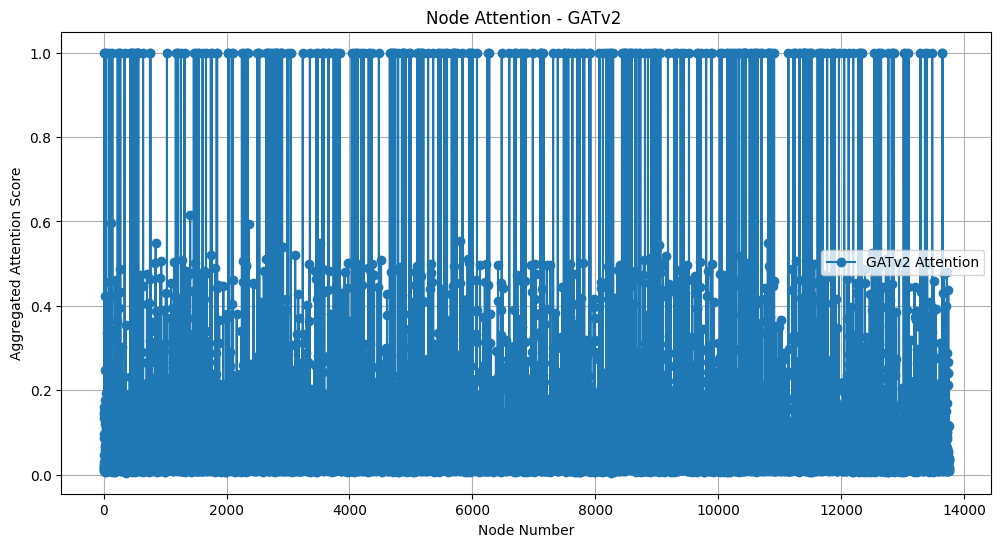

In [ ]:
import matplotlib.pyplot as plt

# Assuming node numbers are simply a range from 0 to the number of nodes - 1
node_numbers = range(len(gat_attention_mean))  # Adjust this if you have a different set of node numbers

plt.figure(figsize=(12, 6))
plt.plot(node_numbers, gat_attention_mean, label='GATv2 Attention', marker='o')
# plt.plot(node_numbers, trans_attention_mean, label='Graph Transformer Attention', marker='x')

plt.title('Node Attention - GATv2 ')
plt.xlabel('Node Number')
plt.ylabel('Aggregated Attention Score')
plt.legend()
plt.grid(True)
plt.show()

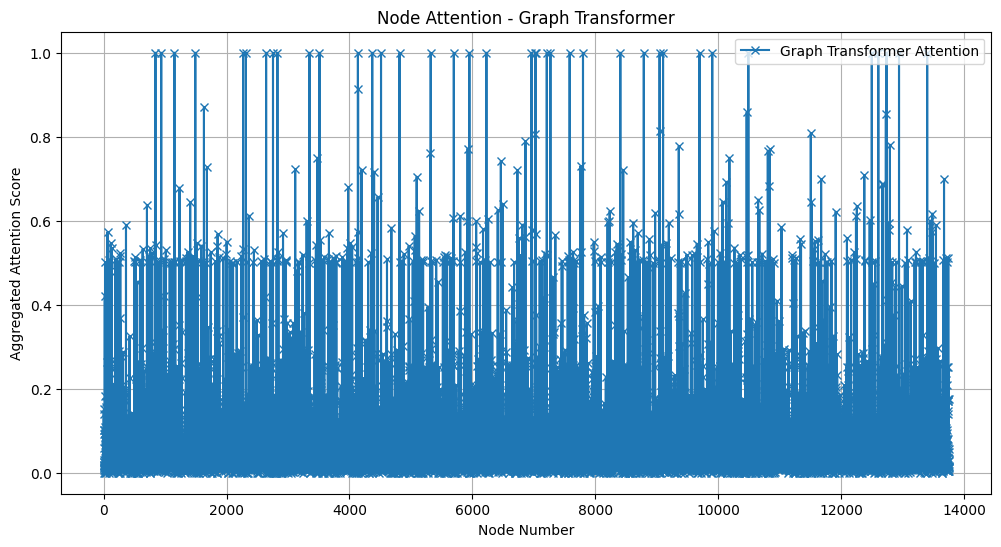

In [ ]:
import matplotlib.pyplot as plt

# Assuming node numbers are simply a range from 0 to the number of nodes - 1
node_numbers = range(len(gat_attention_mean))  # Adjust this if you have a different set of node numbers

plt.figure(figsize=(12, 6))
# plt.plot(node_numbers, gat_attention_mean, label='GATv2 Attention', marker='o')
plt.plot(node_numbers, trans_attention_mean, label='Graph Transformer Attention', marker='x')

plt.title('Node Attention - Graph Transformer')
plt.xlabel('Node Number')
plt.ylabel('Aggregated Attention Score')
plt.legend()
plt.grid(True)
plt.show()

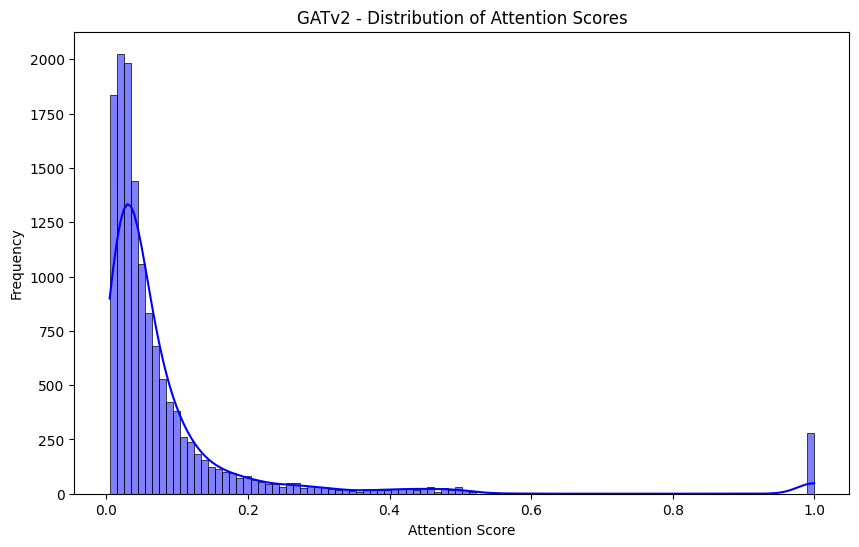

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(gat_attention_mean, kde=True, bins=100, color='blue')
plt.title('GATv2 - Distribution of Attention Scores')
plt.xlabel('Attention Score')
plt.ylabel('Frequency')
plt.show()

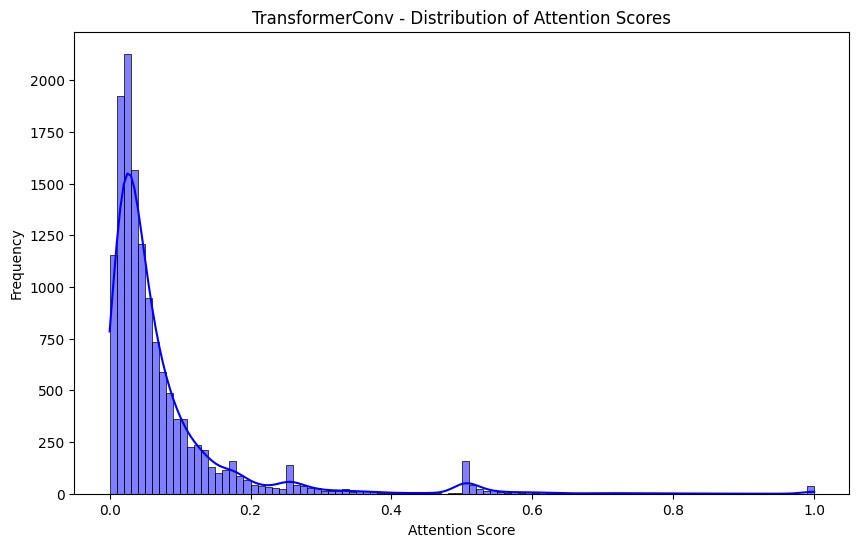

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(trans_attention_mean, kde=True, bins=100, color='blue')
plt.title('TransformerConv - Distribution of Attention Scores')
plt.xlabel('Attention Score')
plt.ylabel('Frequency')
plt.show()